# Источники данных и их верификация, корректировка и подготовка к прогнозированию

Качество прогноза во многом зависит от качества данных, которые мы берем за основу. Для построения прогноза методами анализа временных рядов надо иметь сопоставимые данные не менее чем за три года.

Подготовка данных:
- Регистрация расхода на обычном источнике отгрузки/обслуживания.
- Регистрация расхода, когда товар или услуга потребовались покупателю/внутреннему клиенту (а не когда был отгружен).
- Регистрируйте то, что просил клиент (а не то, что в итоге получил).
- Исключите из статистики внутренние перемещения.
- Корректировка дефицита (отложенный спрос).
- Корректировка нетипичных продаж (скачок продаж, распродажи, спад продаж).

Корректировать нестандартные события можно несколькими способами:
- Усреднение по двум соседним точкам.
- Скользящая средняя.
- Результаты предыдущего периода.
- Данные за аналогичный период в прошлые годы.
- Экспертное заключение.

Т.е. фактически необходимо смоделировать количество событий в нормальной ситуации.

При корректировке важно учитывать возможно возникший отложенный спрос. В таких ситуациях оптимально фиксировать дефицит, чтобы построить прогноз по реальному спросу.

# Загрузка данных и библиотек

Загрузим две основные библиотеки, которые нам потребуются:

In [1]:
import pandas as pd
import numpy as np

Чтобы минимизировать количество кода, запустим выполним часть заранее подготовленного кода из файла *f2forecast.py*. Это позволит нам одной командой загрузить все необходимые библиотеки и некоторые вспомогательные функции.

In [2]:
%run f2forecast.py

Только что были загружены необходимые библиотеки и функции. Учтите, пожалуйста, что без этой библиотеки не будет работать часть методов.

Загрузим файл с данными:

In [3]:
df=pd.read_excel("forecast_dataset.xlsx", index_col='Xm')
df.head()

,Y
Xm,
2010-01-01,1219.0
2010-02-01,1477.0
2010-03-01,1863.0
2010-04-01,1554.0
2010-05-01,1443.0


In [4]:
df.tail()

,Y
Xm,
2019-03-01,2145.0
2019-04-01,1561.6
2019-05-01,1147.7
2019-06-01,940.6
2019-07-01,1632.5


Методы *.head()* и *.tail()* позволяют вывести первые и последние строки файла с данными.

Сейчас мы загрузили файл “forecast_dataset.xlsx”, чтобы загрузить другой файл. Достаточно поменять название. Обратите внимание на организацию файла: первый столбец должен быть с датами и иметь название ‘Xm’, второй – содержать данные и иметь название 'Y'.

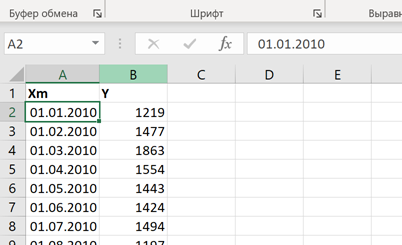

Если книга Excel содержит более одного листа, то можно указать название листа. В этом случае команда будет выглядеть следующим образом:

In [5]:
df=pd.read_excel("forecast_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2010-01-01,1219.0
2010-02-01,1477.0
2010-03-01,1863.0
2010-04-01,1554.0
2010-05-01,1443.0


Где параметру sheet_name мы присваиваем название страницы ‘Data’.

Чтобы проверить ряд на отсутствие пропусков, выполним его валидацию.

In [6]:
df = validate_series(df)
print(df)

                 Y
Xm                
2010-01-01  1219.0
2010-02-01  1477.0
2010-03-01  1863.0
2010-04-01  1554.0
2010-05-01  1443.0
...            ...
2019-03-01  2145.0
2019-04-01  1561.6
2019-05-01  1147.7
2019-06-01   940.6
2019-07-01  1632.5

[115 rows x 1 columns]


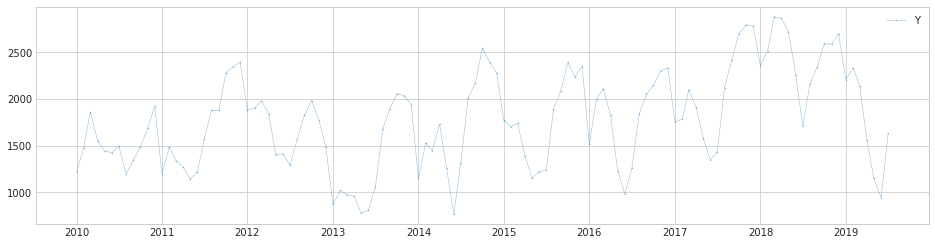

In [7]:
plot(df)

# Выявление и корректировка анномалий

Следующая команда позволяет изучить основные статистики ряда.

In [8]:
df.describe()

,Y
count,115.000000
mean,1777.306957
std,520.343820
min,762.000000
25%,1369.950000
50%,1779.000000
75%,2156.500000
max,2883.400000


Count – количество значений в датасете.

Mean – среднее значение по ряду.

Std – стандартная ошибка. 

Min – минимальное значение. 

25%, 50%, 75% - значения границ квартилей. 50% - это не что иное, как медиана. В нормально распределенных не смещенных данных, как правило, медиана и среднее значение близки друг к другу. 

Max – максимальное значение.

Используя эти данные, посмотрим на данные и возможные выбросы.

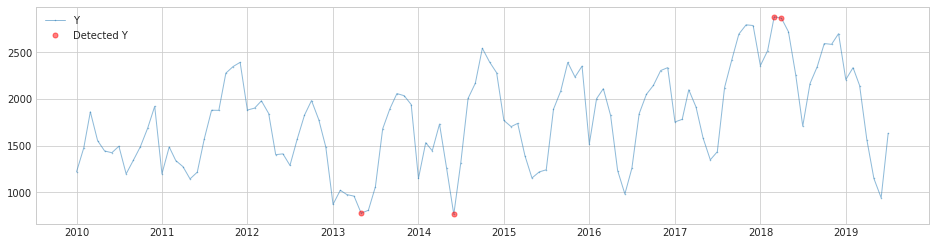

In [9]:
threshold_ad = ThresholdAD(high=2800, low=800)
anomalies = threshold_ad.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True)

Корректируя параметры high и low, можно корректировать область детекции аномалий. Сами аномалии подсвечены красными точками. Чтобы увидеть, какие даты попали в аномалии, достаточно выполнить команду:

In [10]:
anomalies[anomalies.Y]

,Y
Xm,
2013-05-01,True
2014-06-01,True
2018-03-01,True
2018-04-01,True


Воспользуемся более сложным детектором аномалий. Следующий детектор основан на оценке отклонения образца ряда от соседей. Метод оценивает, насколько изолирован объект относительно окружения. Точнее, локальность определяется k-ближайшими соседями, расстояние которых используется для оценки локальной плотности. Сравнивая локальную плотность образца с локальными плотностями его соседей, можно идентифицировать образцы, которые имеют существенно меньшую плотность, чем их соседи. Они считаются выбросами.

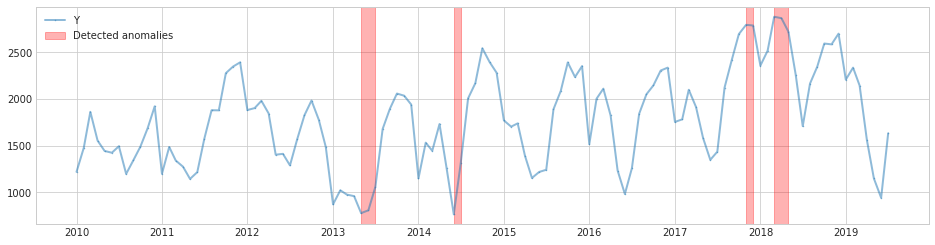

In [11]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=2, ap_color='red', ap_alpha=0.3, curve_group='all');

Аномалии подсвечены красным. Изменяя параметр contamination, можно менять чувствительность модели. Чем больше значение, тем более подозрительно она будет относиться к аномалиям. Посмотреть даты, которые модель подозревает на наличие аномалий, можно командой:

In [12]:
anomalies[anomalies]

Xm
2013-05-01    True
2013-06-01    True
2014-06-01    True
2017-11-01    True
2018-03-01    True
2018-04-01    True
dtype: bool

Последний тест на аномальность – это оценка наличия сезонной компоненты. Построим совмещенные графики по годам. Цифра 12 в параметрах функции означает, сколько периодов длится сезон (если по месяцам – 12, если по кварталам – 4).

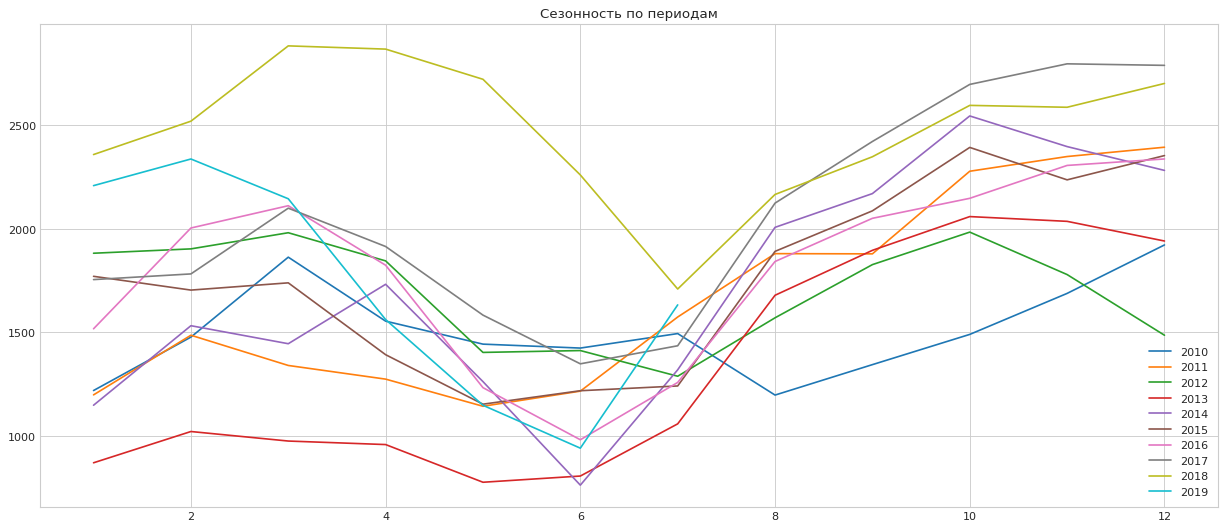

In [13]:
sesonal(df,12)

Итог оценки наличия аномалий в году:
- Релевантными для прогноза являются только данные начиная с 2014 года.
- Первое полугодие 2018 года нуждается в корректировке. 

Чтобы скорректировать, достаточно выполнить команду:


In [14]:
df.loc['2018-01-01']=df.loc['2017-01-01']

In [15]:
df.loc['2018-02-01']=df.loc['2017-02-01']
df.loc['2018-03-01']=df.loc['2017-03-01']
df.loc['2018-04-01']=df.loc['2017-04-01']
df.loc['2018-05-01']=df.loc['2017-05-01']
df.loc['2018-06-01']=df.loc['2017-06-01']

Аналогично повторить для других месяцев 2018 года начиная с февраля и по июнь.

Построим повторно совмещенный график по месяцам, но уже начиная только с 2014 года.

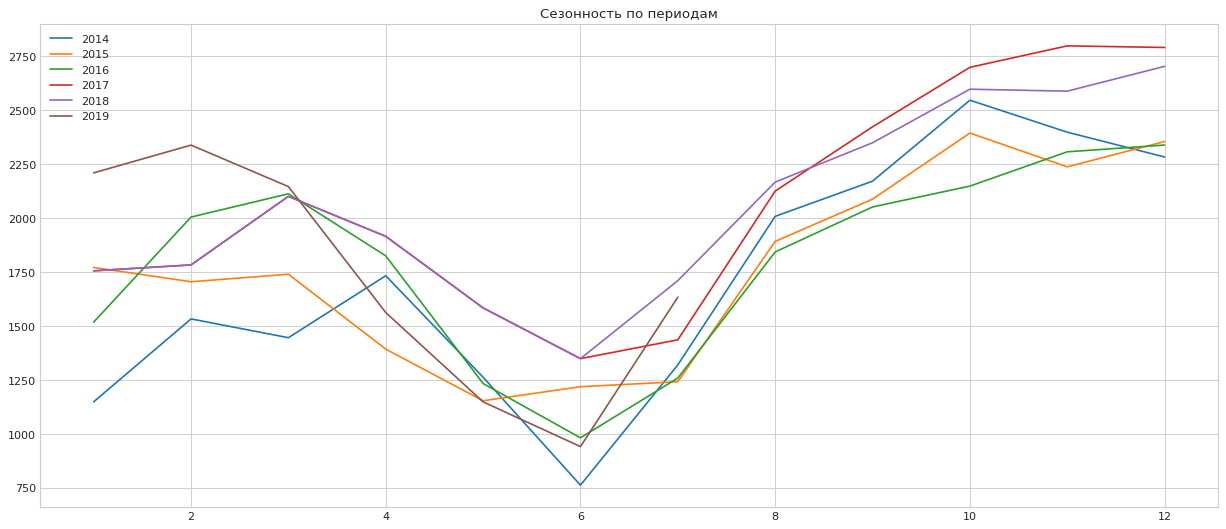

In [16]:
sesonal(df['2014':],12)

В итоге мы получим очищенные данные, пригодные для построения прогноза.

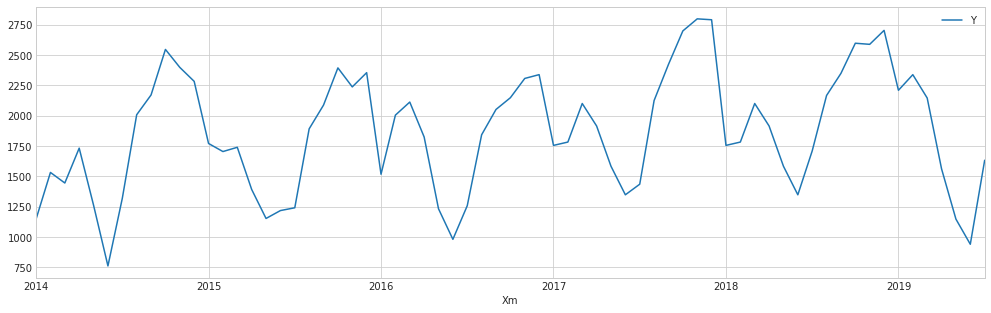

In [17]:
df['2014':].plot(figsize=(17,5))

# Декомпозиция на основе тренда и сезонности

Выделяют три модели представления временного ряда. 
Аддитивная

(Yt)=Tt+St+et

Мультипликативная

(Yt)=Tt×St×et

Смешанная

(Yt)=(Tt+et)×St

где
- (Yt ) ̂- прогнозное значение;
- T – основной сигнал ряда;
- S – коэффициент сезонности;
- e – остатки (ошибка).

Понятие коэффициента сезонности:
- Сезонность - периодические колебания, наблюдаемые на временных рядах.
- Коэффициент сезонности показывает, насколько продажи в данном периоде отклонились от среднего значения.

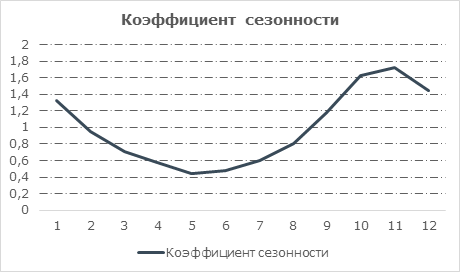

Выполним разложение ряда по мультипликативной модели и изучим результаты.

Text(0.5, 0.98, 'Мультипликативная модель')

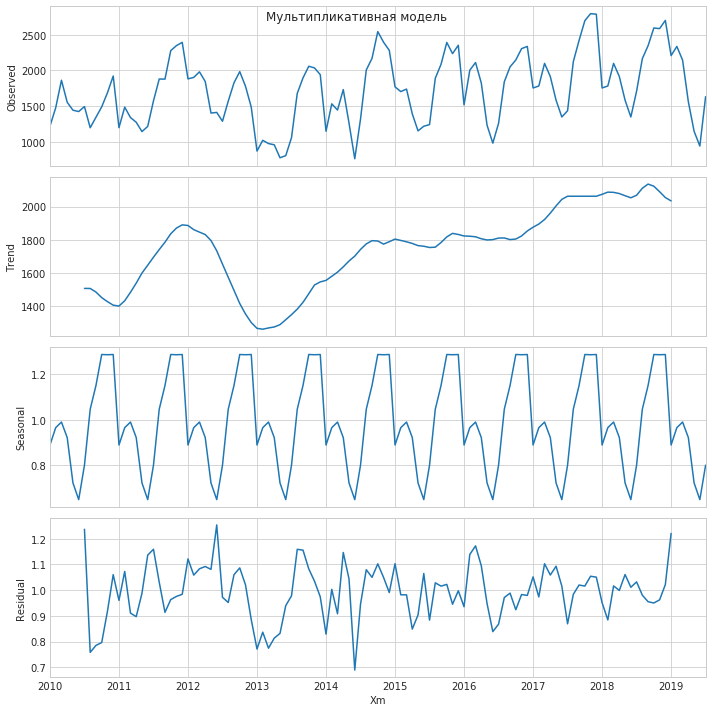

In [18]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', freq=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультипликативная модель')

Обратите внимание на параметр freq. Мы передаем его в модель, чтобы помочь с пониманием количества периодов в одном сезоне. В случае данных с разбивкой по кварталам, freq будет равен 4.

Чтобы получить значения тренда, надо выполнить команду:

In [19]:
result_M.seasonal['2011']

Xm
2011-01-01    0.889458
2011-02-01    0.965701
2011-03-01    0.990442
2011-04-01    0.922185
2011-05-01    0.722648
2011-06-01    0.649300
2011-07-01    0.800671
2011-08-01    1.046831
2011-09-01    1.151338
2011-10-01    1.287503
2011-11-01    1.286512
2011-12-01    1.287412
Freq: MS, Name: Y, dtype: float64

Чтобы получить коэффициенты сезонности, надо выполнить команду:

In [20]:
result_M.trend['2011']

Xm
2011-01-01    1402.666667
2011-02-01    1434.458333
2011-03-01    1485.208333
2011-04-01    1540.333333
2011-05-01    1600.708333
2011-06-01    1647.916667
2011-07-01    1696.083333
2011-08-01    1741.958333
2011-09-01    1786.041667
2011-10-01    1836.541667
2011-11-01    1871.166667
2011-12-01    1890.166667
Freq: MS, Name: Y, dtype: float64

Выполним аддитивное разложение ряда, чтобы посмотреть, какой вариант лучше подходит в нашем случае.

Text(0.5, 0.98, 'Адитивная модель')

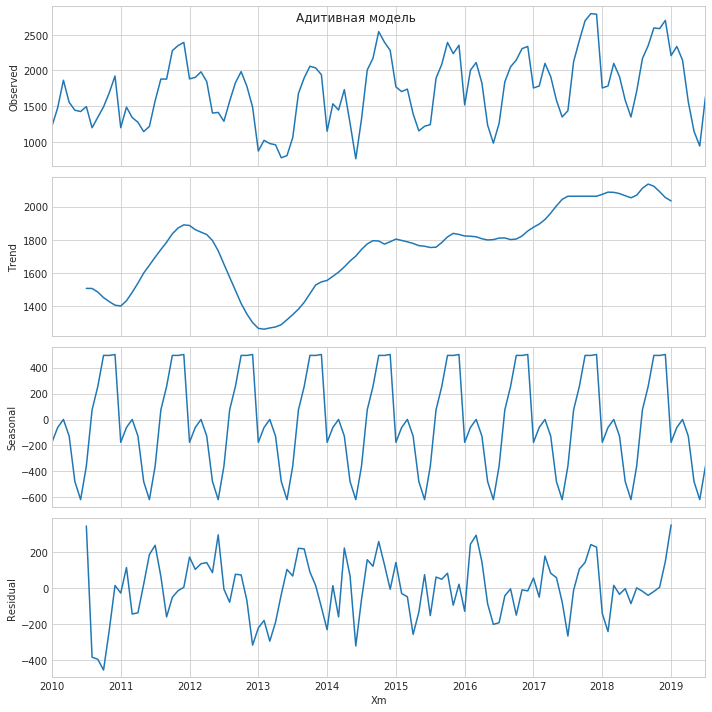

In [21]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

Значения тренда и сезонности мы можем получить аналогичным вышеописанным методом. Единственное, что название модели сменится с result_M на result_A.

#  Оценка качества и точности математических моделей с использованием стандартных метрик (ошибок)

Построим график модели на интервале 2011-2017 годов.

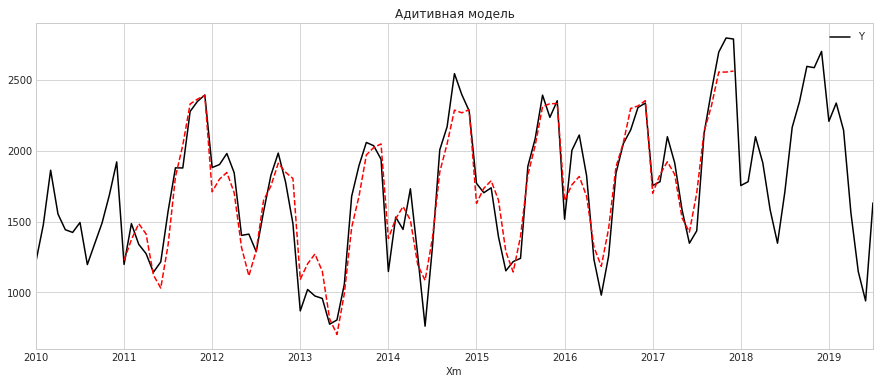

In [22]:
ax = df.plot(figsize=(15,6), color='black', title="Адитивная модель" )
(result_A.trend['2011':'2017']+result_A.seasonal['2011':'2017']).plot(ax=ax, style='--', color='red')
plt.show()

Некоторые комментарии к коду:
- figsize=(15,6) размер картинки по горизонтали и вертикали.
- Color – цвет линии.
- title – название графика.
- style=’—' – заполнение линии, можно изменять. 

Фактически мы сложили значение тренда и сезонности, получив прогноз по нашей модели.

Построим аналогичный график для мультипликативной модели. Но уже перемножим тренд и сезонность. 


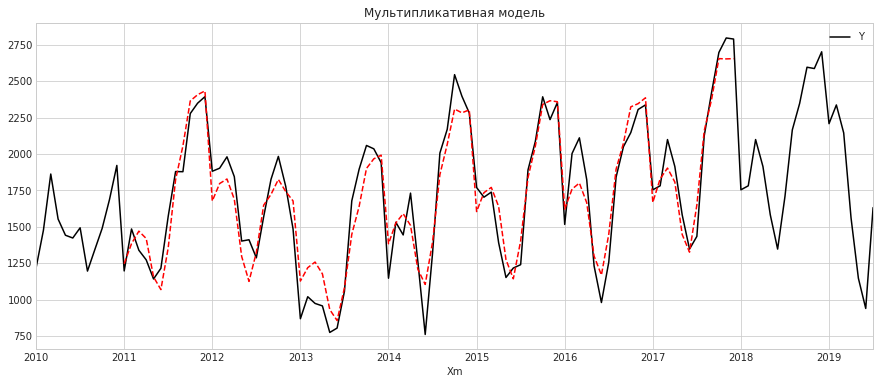

In [23]:
ax = df.plot(figsize=(15,6), color='black', title="Мультипликативная модель" )
(result_M.trend['2011':'2017']*result_M.seasonal['2011':'2017']).plot(ax=ax, style='--', color='red')
plt.show()

Фактически получились графики, не отличимые на первый взгляд. Используем метрики точности моделей, чтобы выбрать наиболее точную.

## Среднее абсолютное отклонение

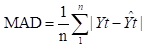

## Среднеквадратическая ошибка 

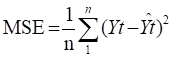

Наиболее важная. Именно на нее обращают внимание в первую очередь, когда сравнивают точность методов между собой. Уменьшение этой ошибки приводит к уменьшению всех остальных ошибок.

## Средняя абсолютная ошибка в процентах

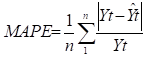

## Средняя процентная ошибка

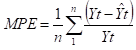

## Тест на стационарность Дики-Фуллера

Тест Дики-Фуллера (DF-тест, Dickey-Fuller test) — это методика, которая используется в прикладной статистике и эконометрике при анализе временных рядов для проверки на стационарность. Является одним из тестов на единичные корни (Unit root test). Был предложен в 1979 году Дэвидом Дики (англ.) и Уэйном Фуллером.
За вклад в исследование коинтегрированных процессов с использованием предложенного теста проверки на стационарность Дики-Фуллера в 2003 году Клайв Грейнджер (Clive Granger) получил Нобелевскую премию по экономике.
Существует три версии теста (тестовых регрессий):
- Без константы и тренда
- С константой, но без тренда:
- С константой и линейным трендом:
 
Для каждой из трех тестовых регрессий существуют свои критические значения DF-статистики, которые берутся из специальной таблицы Дики-Фуллера (МакКиннона). Если значение статистики лежит левее критического значения (критические значения — отрицательные) при данном уровне значимости, то нулевая гипотеза о единичном корне отклоняется и процесс признается стационарным (в смысле данного теста). В противном случае гипотеза не отвергается и процесс может содержать единичные корни, то есть быть нестационарным (интегрированным) временным рядом.

Мы тестируем остатки на стационарность, чтобы понимать, что наша модель смогла извлечь все закономерности из ряда. В противном случае модель использовать нельзя.

## Доверительные интервалы

Упрощенно формулу 95% доверительного интервала можно представить как:

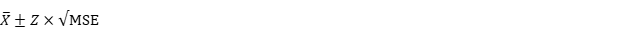

где

Z – двусторонние 95%-ные процентили для t(n)-распределений, в простом случае берем равным 2.

Корень из MSE – это приблизительное значение стандартной ошибки. 

Например, если мы возьмем только одну стандартную ошибку в каждую сторону от прогнозного значения, то получим 68% доверительного интервала. А три стандартные ошибки в каждую сторону дадут уже 95% доверительного интервала.

Найдем метрики для наших моделей. Для аддитивной модели нам надо сложить значения тренда и сезонности. Для мультипликативной – перемножить.

Ниже, как раз сложение сезонной компоненты и тренда даст значение модели.

In [24]:
result_A.trend['2011':'2017']+result_A.seasonal['2011':'2017']

Xm
2011-01-01    1226.989868
2011-02-01    1373.144497
2011-03-01    1485.707518
2011-04-01    1412.755956
2011-05-01    1122.938768
                 ...     
2017-08-01    2136.862090
2017-09-01    2316.774590
2017-10-01    2556.167183
2017-11-01    2555.888016
2017-12-01    2563.059775
Freq: MS, Name: Y, Length: 84, dtype: float64

Используем уже написанную функцию для расчета всех метрик.

In [25]:
metrics(df['2011':'2017'], result_A.trend['2011':'2017']+result_A.seasonal['2011':'2017'])

Тест на стационарность:
	T-статистика = -5.512
	P-значение = 0.000
Критические значения :
	1%: -3.5117123057187376 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8970475206326833 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5857126912469153 - Данные  стационарны с вероятностью 90% процентов
MAD: 123.6173
MSE: 22579.475
MAPE: 0.0832
MPE: -0.0103
Стандартная ошибка: 150.2647


T-статистика должна выходить за интервал [-2,5 : 2,5].

P-значение должно быть меньше 0,05.

Если значения не соответствуют требованиям – ряд нестационарен. В данном случае модель адекватна, остатки стационарны.

In [26]:
metrics(df['2011':'2017'], result_M.trend['2011':'2017']*result_M.seasonal['2011':'2017'])

Тест на стационарность:
	T-статистика = -5.677
	P-значение = 0.000
Критические значения :
	1%: -3.5117123057187376 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8970475206326833 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5857126912469153 - Данные  стационарны с вероятностью 90% процентов
MAD: 124.1204
MSE: 21989.7463
MAPE: 0.0843
MPE: -0.0143
Стандартная ошибка: 148.2894


Модели очень похожи по показателям между собой. Чуть более точной является мультипликативная модель. 

# Тренировочные и тестовые наборы

Чтобы иметь возможность более качественно оценивать модель, разделим данные на тренировочные и тестовые. Часть данных мы «спрячем» от модели и будем пробовать их предсказать.

In [27]:
train=df['2014':'2018']
train.head()

,Y
Xm,
2014-01-01,1148.0
2014-02-01,1532.0
2014-03-01,1445.0
2014-04-01,1732.0
2014-05-01,1262.0


Тестовые данные возьмем за 7 месяцев 2019 года. 

In [28]:
test=df['2019']
df.head()

,Y
Xm,
2010-01-01,1219.0
2010-02-01,1477.0
2010-03-01,1863.0
2010-04-01,1554.0
2010-05-01,1443.0


# Модель Хольта-Винтерса

Модель Хольта-Винтерса использует идеи модели экспоненциального сглаживания, но является более сложной и может применяться к рядам, содержащим тенденцию и сезонность. 

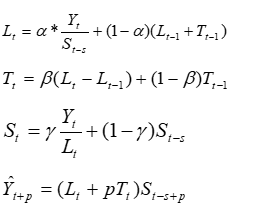

где

Lt – новая сглаженная величина;

α – постоянная сглаживания для данных (0 ≤ α ≥ 1);

Yt – новое наблюдение или реальное значение ряда в период t;

β - постоянная сглаживания для оценки тренда (0 ≤ β ≤1);

Тt - собственно оценка тренда;

(гамма) - постоянная сглаживания для оценки сезонности;

St – оценка сезонности; 

s – длительность периода сезонного колебания;

р – количество периодов вперед, на которое делается прогноз;

Ŷ t+p - прогноз на р периодов вперед.

К счастью, модель реализована в одной из библиотек Python и мы не будем воспроизводить все формулы.

In [29]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [30]:
fit1.params

{'smoothing_level': 0.05263157894736842,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.5263157894736842,
 'damping_slope': nan,
 'initial_level': 1589.02,
 'initial_slope': 4.008333333333333,
 'initial_seasons': array([0.72245787, 0.96411625, 0.90936552, 1.08997999, 0.7942002 ,
        0.47954085, 0.83007136, 1.26304263, 1.36562158, 1.60161609,
        1.50847692, 1.43610527]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Первая команда «тренирует» модель fit1. В данном случае реализована классическая модель с аддитивным трендом и мультипликативной сезонной компонентой. Но мы можем построить модель вида в части сочетаний аддитивной и мультипликативной моделей. 

Обратите внимание на параметр seasonal_periods – мы подсказываем модели количество сезонов. Этот параметр необходимо изменить при прогнозировании по кварталам.

Из параметров модели нам интересны:
- 'smoothing_level', 'smoothing_slope', 'smoothing_seasonal' – это постоянные сглаживания для основного ряда данных, тренда и сезонности; 
- 'initial_level' – начальный уровень основного ряда данных; 
- 'initial_slope' – начальный уровень тренда; 
- 'initial_seasons' – начальные значения коэффициентов сезонности.

Мы можем получить расчетные значения для модели и рассчитать метрики точности.


In [31]:
fit1.fittedvalues

Xm
2014-01-01    1150.895852
2014-02-01    1539.514899
2014-03-01    1455.330387
2014-04-01    1748.029540
2014-05-01    1276.165107
2014-06-01     771.950949
2014-07-01    1338.469640
2014-08-01    2039.779061
2014-09-01    2208.573647
2014-10-01    2593.594654
2014-11-01    2445.635568
2014-12-01    2330.759596
2015-01-01    1172.078349
2015-02-01    1609.557770
2015-03-01    1526.390647
2015-04-01    1848.038713
2015-05-01    1331.944213
2015-06-01     800.046963
2015-07-01    1427.594722
2015-08-01    2163.747943
2015-09-01    2330.274863
2015-10-01    2724.733049
2015-11-01    2555.536841
2015-12-01    2421.677501
2016-01-01    1562.254596
2016-02-01    1693.284029
2016-03-01    1681.677950
2016-04-01    1660.017543
2016-05-01    1302.016712
2016-06-01    1078.382675
2016-07-01    1360.220140
2016-08-01    2071.717504
2016-09-01    2258.600132
2016-10-01    2615.712595
2016-11-01    2439.654221
2016-12-01    2445.529389
2017-01-01    1574.707935
2017-02-01    1914.239920
2017-03-0

In [32]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -4.913
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
MAD: 162.1135
MSE: 43319.4022
MAPE: 0.0894
MPE: -0.0049
Стандартная ошибка: 208.1331


Рассчитаем прогноз на 12 месяцев вперед.

In [33]:
fit1.forecast(12)

2019-01-01    1853.171855
2019-02-01    1959.691893
2019-03-01    2240.760410
2019-04-01    2039.876118
2019-05-01    1639.497734
2019-06-01    1378.217127
2019-07-01    1665.279249
2019-08-01    2259.835020
2019-09-01    2494.004563
2019-10-01    2765.230246
2019-11-01    2794.721654
2019-12-01    2924.278491
Freq: MS, dtype: float64

Построим график с фактическими данными, значением модели и прогнозом. 

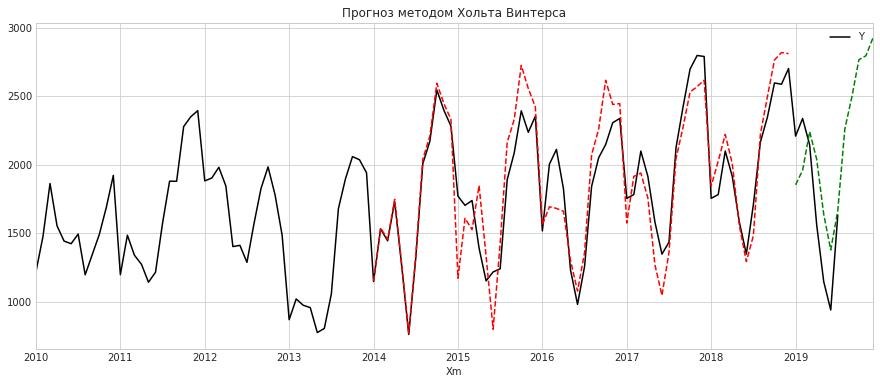

In [34]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Изменяя параметры trend и seasonal, построим еще три модели и сравним их точность. Также все три модели сравним по точности предсказания тестовых данных.

In [35]:
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()

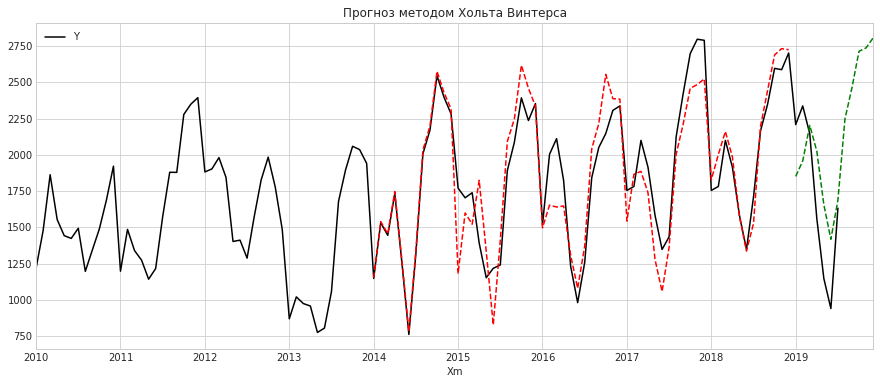

In [36]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )

fit2.fittedvalues.plot(ax=ax, style='--', color='red')

#добавим на график прогноз
#(!!!!) обратите внимание, что fit1 - имя модели, может потребоваться изменить при повторном использовании кода
fit2.forecast(12).plot(ax=ax, style='--', color='green')

#отобразим график
plt.show()

In [37]:
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -5.020
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
MAD: 147.9921
MSE: 39253.5303
MAPE: 0.0823
MPE: 0.0072
Стандартная ошибка: 198.125


In [38]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -4.913
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
MAD: 162.1135
MSE: 43319.4022
MAPE: 0.0894
MPE: -0.0049
Стандартная ошибка: 208.1331


In [39]:
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -5.020
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
MAD: 147.9921
MSE: 39253.5303
MAPE: 0.0823
MPE: 0.0072
Стандартная ошибка: 198.125


Изменяя параметры trend и seasonal, построим еще три модели и сравним их точность. Также все три модели сравним по точности предсказания тестовых данных.

In [40]:
metrics(test, fit1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -3.464
	P-значение = 0.009
Критические значения :
	1%: -6.045114 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.9292800000000003 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.98681 - Данные  стационарны с вероятностью 90% процентов
MAD: 324.1381
MSE: 134437.3301
MAPE: 0.2267
MPE: -0.1346
Стандартная ошибка: 366.657


Мы видим, что на тестовых данных точность предсказания падает. На стационарность остатков можно не обращать внимания, так как их немного.

В итоге выберем модель, которая имеет более высокую точность предсказания именно тестовых данных. Чтобы построить прогноз на год вперед возьмем полный набор известных данных (тренировочные + тестовые).

# SARIMA

Один из наиболее распространенных методов, используемых в прогнозировании временных рядов, известен как модель ARIMA, которая обозначает авторегрессию интегрированного скользящего среднего (ARIMA - от AutoRegressive Integrated Moving Average). ARIMA - это модель, которая может быть адаптирована к данным временного ряда, чтобы лучше понять или предсказать будущие точки в ряду.

Есть три различных целых числа (p, d, q), которые используются для параметризации.

р - авторегрессионная часть модели. Позволяет нам включить влияние прошлых значений в нашу модель. Например, это было бы похоже на заявление о том, что завтра может быть тепло, если последние 3 дня были теплыми.

d является неотъемлемой частью модели. Указывает на количество разностей (то есть количество прошлых временных точек, которые необходимо вычесть из текущего значения) для применения к временному ряду. Например, это может быть похоже на утверждение, что завтра будет такая же температура, если разница в температуре за последние 3 дня была очень мала.

q - скользящая средняя часть модели. Это позволяет нам установить ошибку нашей модели как линейную комбинацию значений ошибок, наблюдаемых в предыдущие моменты времени в прошлом.

При работе с сезонными эффектами мы используем сезонную ARIMA, которая обозначается как SARIMA (p, d, q) (P, D, Q) s.
Здесь (p, d, q) - несезонные параметры, описанные выше, в то время как (P, D, Q) следуют тому же определению, но применяются к сезонной компоненте временного ряда.

Термин s - это периодичность временного ряда (4 для квартальных периодов, 12 для годовых периодов и т.д.).

Сезонный метод ARIMA может показаться пугающим из-за множества параметров настройки, но мы автоматизируем процесс подбора параметров модели.

При поиске соответствия данных временных рядов сезонной модели ARIMA нашей первой целью является поиск значений ARIMA (p, d, q) (P, D, Q), которые оптимизируют интересующую метрику. Мы будем использовать «поиск по сетке», чтобы итеративно исследовать различные комбинации параметров. 

Подбор параметров модели обычно ведут при помощи изучения графика автокорреляции. 

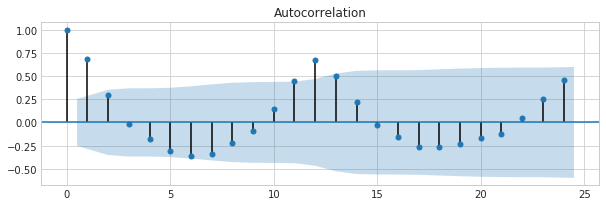

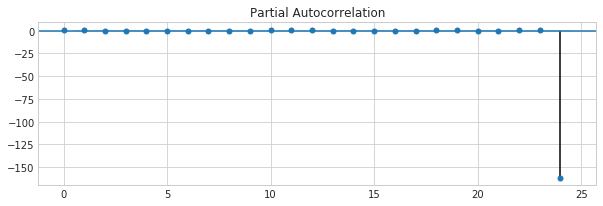

In [41]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.Y, lags=24)
plot_pacf(train.Y, lags=24)
plt.show()

Например, мы видим, что в ряду есть тренд и сезонная компонента. 

Подберем параметры модели.

In [42]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=853.317, BIC=870.072, Fit time=2.938 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=916.842, BIC=921.030, Fit time=0.232 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=835.186, BIC=843.563, Fit time=2.269 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=865.723, BIC=874.101, Fit time=1.099 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1080.778, BIC=1082.872, Fit time=0.010 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=876.843, BIC=883.126, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=826.553, BIC=837.025, Fit time=5.694 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=833.470, BIC=843.942, Fit time=2.593

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

Рассчитаем наиболее точную модель.

In [43]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 0),
                                seasonal_order=(2, 0, 0, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9162      0.054     16.814      0.000       0.809       1.023
ar.S.L12       0.2815      0.082      3.448      0.001       0.122       0.441
ar.S.L24       0.6452      0.093      6.913      0.000       0.462       0.828
sigma2      3.323e+04   8916.089      3.728      0.000    1.58e+04    5.07e+04


Построим диагностические графики для полученной модели.

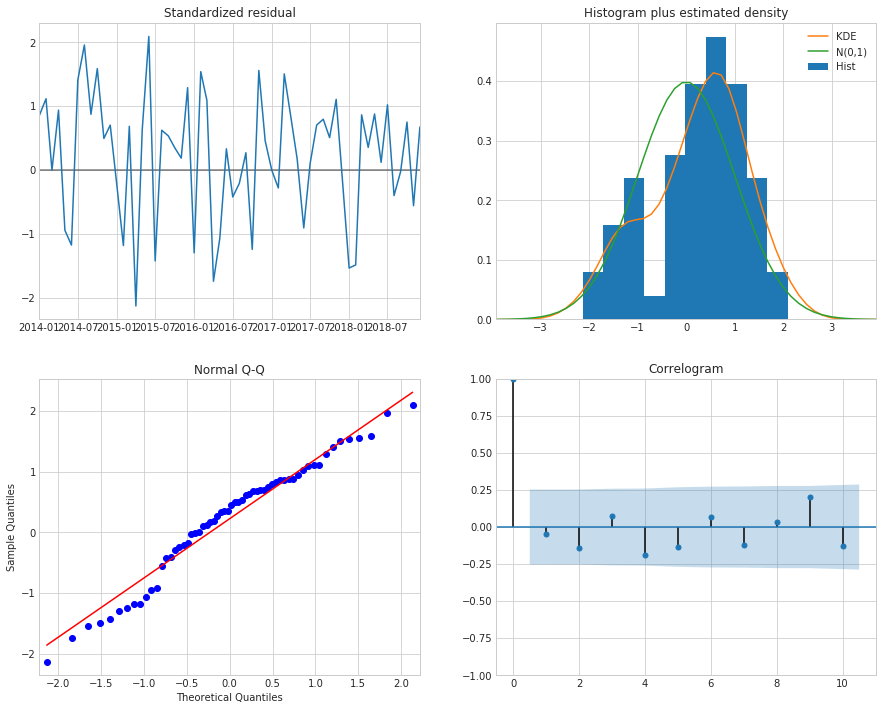

In [44]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Оценим точность нашей модели по стандартным метрикам. Но учтем, что модель не строит прогноз для первого периода. Это можно увидеть, выведя результаты и не задавая начальную дату.

In [45]:
predict=results.get_prediction()
predict.predicted_mean[:10]

Xm
2014-01-01       0.000000
2014-02-01    1098.507620
2014-03-01    1445.311104
2014-04-01    1369.425252
2014-05-01    1624.916200
2014-06-01    1212.147488
2014-07-01     781.341703
2014-08-01    1265.924145
2014-09-01    1842.786955
2014-10-01    1958.670617
Freq: MS, dtype: float64

In [46]:
predict=results.get_prediction(start=pd.to_datetime('2014-02-01'))
metrics(train['2014-02-01':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -5.455
	P-значение = 0.000
Критические значения :
	1%: -3.5506699942762414 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.913766394626147 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5946240473991997 - Данные  стационарны с вероятностью 90% процентов
MAD: 201.5699
MSE: 66330.3197
MAPE: 0.121
MPE: 0.02
Стандартная ошибка: 257.5467


Сделаем прогноз на два года вперед и построим график.

In [47]:
predict=results.get_prediction(start='2019', end='2021')

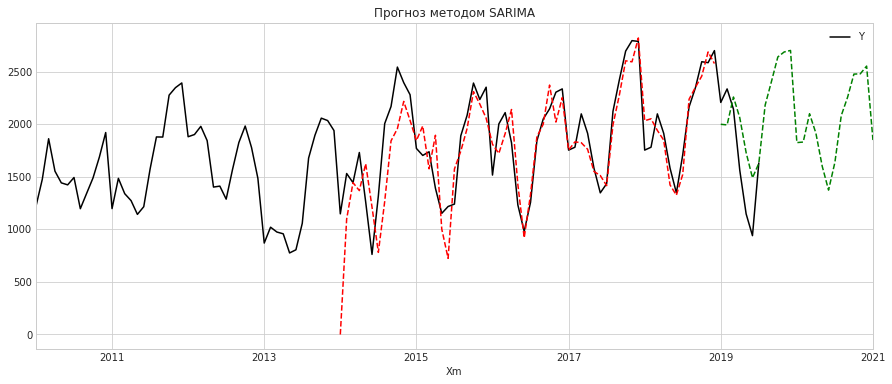

In [48]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

Оценим модель на точность по тестовым данным. 

In [49]:
predict=results.get_prediction(start='2019-01-01', end='2019-07-01')
metrics(test, predict.predicted_mean)

Тест на стационарность:
	T-статистика = -2.924
	P-значение = 0.043
Критические значения :
	1%: -6.045114 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.9292800000000003 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.98681 - Данные не стационарны с вероятностью 90% процентов
MAD: 329.0728
MSE: 152466.2075
MAPE: 0.2444
MPE: -0.1749
Стандартная ошибка: 390.4692


Для прогнозирования будущих периодов необходимо обучить модель на полном наборе данных. Чтобы отобразить результаты прогноза или получить их для редактирования, надо выдать команду:

In [50]:
predict.predicted_mean

2019-01-01    2000.505866
2019-02-01    1994.523922
2019-03-01    2260.017090
2019-04-01    2062.142498
2019-05-01    1730.893785
2019-06-01    1490.819114
2019-07-01    1628.533198
Freq: MS, dtype: float64

Для экспертного прогнозирования желательно присвоить значения прогноза другой переменной. Редактировать/присваивать новые значения можно, обращаясь по индексу.

In [51]:
res_forecast=predict.predicted_mean

In [52]:
res_forecast['2019-01-01']=2000

In [53]:
res_forecast

2019-01-01    2000.000000
2019-02-01    1994.523922
2019-03-01    2260.017090
2019-04-01    2062.142498
2019-05-01    1730.893785
2019-06-01    1490.819114
2019-07-01    1628.533198
Freq: MS, dtype: float64

Также данные легко преобразовать в квартальные, если мы будем делать прогноз по кварталам. 

In [54]:
df=df[:'2019-06-01'].resample('Q').sum()
df.tail()

,Y
Xm,
2018-06-30,4845.5
2018-09-30,6222.9
2018-12-31,7884.8
2019-03-31,6690.6
2019-06-30,3649.9


Обратите только внимание, что надо ограничить период таким образом, чтобы у нас формировались полные кварталы. В 2019 году у нас есть только два полных квартала. 